In [ ]:
"""
Purpose: To Run the proofreading of neurons in the 
test set and measure the precision and recall of the new rules

Segments to look out for that had no axon
864691135012395766 # one of the split segments files not there (split index = 1)
864691135865584005 #soma soma merger
864691136451113215 #it was an inhibitory neuron (part of split)

"""

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import datajoint as dj
import trimesh
from tqdm.notebook import tqdm
from pathlib import Path

from os import sys
sys.path.append("/meshAfterParty/")
sys.path.append("/meshAfterParty/meshAfterParty")

import datajoint_utils as du
from importlib import reload

INFO - 2021-06-03 16:35:33,518 - settings - Setting database.host to at-database.ad.bcm.edu
INFO - 2021-06-03 16:35:33,520 - settings - Setting database.user to celiib
INFO - 2021-06-03 16:35:33,522 - settings - Setting database.password to newceliipass
INFO - 2021-06-03 16:35:33,527 - settings - Setting stores to {'minnie65': {'protocol': 'file', 'location': '/mnt/dj-stor01/platinum/minnie65', 'stage': '/mnt/dj-stor01/platinum/minnie65'}, 'meshes': {'protocol': 'file', 'location': '/mnt/dj-stor01/platinum/minnie65/02/meshes', 'stage': '/mnt/dj-stor01/platinum/minnie65/02/meshes'}, 'decimated_meshes': {'protocol': 'file', 'location': '/mnt/dj-stor01/platinum/minnie65/02/decimated_meshes', 'stage': '/mnt/dj-stor01/platinum/minnie65/02/decimated_meshes'}, 'skeletons': {'protocol': 'file', 'location': '/mnt/dj-stor01/platinum/minnie65/02/skeletons'}}
INFO - 2021-06-03 16:35:33,528 - settings - Setting enable_python_native_blobs to True
INFO - 2021-06-03 16:35:33,542 - connection - Connect

Connecting celiib@at-database.ad.bcm.edu:3306


INFO - 2021-06-03 16:35:34,111 - settings - Setting enable_python_native_blobs to True
INFO - 2021-06-03 16:35:34,115 - settings - Setting database.host to at-database.ad.bcm.edu
INFO - 2021-06-03 16:35:34,116 - settings - Setting database.user to celiib
INFO - 2021-06-03 16:35:34,117 - settings - Setting database.password to newceliipass
INFO - 2021-06-03 16:35:34,119 - settings - Setting database.host to at-database.ad.bcm.edu
INFO - 2021-06-03 16:35:34,120 - settings - Setting database.user to celiib
INFO - 2021-06-03 16:35:34,121 - settings - Setting database.password to newceliipass
INFO - 2021-06-03 16:35:34,123 - settings - Setting enable_python_native_blobs to True
INFO - 2021-06-03 16:35:34,698 - settings - Setting enable_python_native_blobs to True


In [3]:
#configuring will include the adapters
minnie,schema = du.configure_minnie_vm()

INFO - 2021-06-03 16:35:34,859 - settings - Setting database.host to at-database.ad.bcm.edu
INFO - 2021-06-03 16:35:34,860 - settings - Setting database.user to celiib
INFO - 2021-06-03 16:35:34,861 - settings - Setting database.password to newceliipass
INFO - 2021-06-03 16:35:34,865 - settings - Setting enable_python_native_blobs to True
INFO - 2021-06-03 16:35:35,541 - settings - Setting enable_python_native_blobs to True


In [4]:
import validation_utils as vu
import neuron_visualizations as nviz
import neuron_utils as nru
import proofreading_utils as pru
import time
import system_utils as su

# Getting the Results of the Validation

In [5]:
minnie.AutoProofreadValidationScore5() 

ver materialization version,nucleus_id nucleus id,segment_id the segment id in the proofread version,old_ver materialization version,split_index the index of the neuron object that resulted AFTER THE SPLITTING ALGORITHM,decomposition saved neuron object with high fidelity axon,axon_length axon length of the filtered neuron,validation_df,validation_df_ext,pre_tp,pre_tn,pre_fp,pre_fn,pre_precision,pre_recall,pre_f1,post_tp,post_tn,post_fp,post_fn,post_precision,post_recall,post_f1,run_time the amount of time to run (seconds)
88.00,189149,864691135855890478,0.08,0,=BLOB=,369.84999619148164,=BLOB=,=BLOB=,7,160,11,0,0.3888888888888889,1.0,0.56,5281,7,39,3,0.9926691729323308,0.9994322482967449,0.9960392304790645,419.79
88.00,223037,864691136227167569,0.08,0,=BLOB=,63.375728490237755,=BLOB=,=BLOB=,0,450,0,0,nan,nan,nan,1,3410,3859,0,0.00025906735751295336,1.0,0.000518000518000518,287.47
88.00,225498,864691135753932237,0.08,0,=BLOB=,185.8554437449504,=BLOB=,=BLOB=,6,77,0,5,1.0,0.5454545454545454,0.7058823529411764,1124,0,0,9,1.0,0.9920564872021183,0.9960124058484714,114.89
88.00,230236,864691135609687047,0.08,0,=BLOB=,1573.0087006301437,=BLOB=,=BLOB=,34,550,11,16,0.7555555555555555,0.68,0.7157894736842104,1961,22,1,1,0.9994903160040775,0.9994903160040775,0.9994903160040775,423.5
88.00,236197,864691136903144370,0.08,0,=BLOB=,40.753447012345966,=BLOB=,=BLOB=,0,975,0,5,nan,0.0,nan,2750,2329,7,48,0.9974610083424011,0.9828448892065761,0.99009900990099,466.12
88.00,258307,864691135293126156,0.08,0,=BLOB=,1095.334412475715,=BLOB=,=BLOB=,43,335,17,27,0.7166666666666667,0.6142857142857143,0.6615384615384615,2984,7,25,19,0.9916915918909937,0.9936729936729937,0.9926813040585496,346.12
88.00,262773,864691136023889209,0.08,0,=BLOB=,191.70683649485437,=BLOB=,=BLOB=,9,48,2,0,0.8181818181818182,1.0,0.9,724,0,2,10,0.9972451790633609,0.9863760217983651,0.9917808219178083,98.98
88.00,264870,864691136951664863,0.08,0,=BLOB=,1021.2379299332463,=BLOB=,=BLOB=,31,422,2,1,0.9393939393939394,0.96875,0.9538461538461539,2008,25,4,33,0.9980119284294234,0.9838314551690348,0.9908709597828769,265.38
88.00,269247,864691135584074360,0.08,0,=BLOB=,2058.547022789378,=BLOB=,=BLOB=,209,65,0,10,1.0,0.954337899543379,0.9766355140186915,807,0,7,64,0.9914004914004914,0.9265212399540758,0.9578635014836795,406.2
88.00,269380,864691135974639471,0.08,0,=BLOB=,437.8471079089947,=BLOB=,=BLOB=,27,257,4,11,0.8709677419354839,0.7105263157894737,0.782608695652174,1863,4,8,3,0.9957242116515232,0.9983922829581994,0.9970564624029972,269.68


In [7]:
training_set = minnie.AutoProofreadValidationSegment.proj(old_segment_id="segment_id").fetch("old_segment_id")      

In [8]:
validation_table_pd = vu.current_validation_df()

INFO - 2021-06-03 16:35:52,540 - settings - Setting database.host to at-database.ad.bcm.edu
INFO - 2021-06-03 16:35:52,541 - settings - Setting database.user to celiib
INFO - 2021-06-03 16:35:52,542 - settings - Setting database.password to newceliipass
INFO - 2021-06-03 16:35:52,546 - settings - Setting enable_python_native_blobs to True
INFO - 2021-06-03 16:35:53,301 - settings - Setting enable_python_native_blobs to True


In [9]:
validation_table_pd

,ver,nucleus_id,segment_id,old_ver,split_index,validation_df,validation_df_ext,old_segment_id,n_somas,n_soma_mergers,n_glia
0,88.00,189149,864691135855890478,0.08,0,synapse_id synapse_type auto_valid synaps...,"[[76963424, presyn, True, 521800, 532392, 9724...",864691135585319036,1,0,0
1,88.00,223037,864691136227167569,0.08,0,synapse_id synapse_type auto_valid synaps...,"[[51413779, presyn, False, 470296, 499972, 913...",864691135538120050,2,0,0
2,88.00,225498,864691135753932237,0.08,0,synapse_id synapse_type auto_valid synaps...,"[[108139963, presyn, True, 602432, 651712, 692...",864691135564655959,1,0,0
3,88.00,230236,864691135609687047,0.08,0,synapse_id synapse_type auto_valid synaps...,"[[108633620, presyn, True, 587600, 769720, 796...",864691135748568361,1,0,0
4,88.00,236197,864691136903144370,0.08,0,synapse_id synapse_type auto_valid synaps...,"[[26842646, presyn, False, 397472, 700268, 656...",864691135758569550,2,0,2
...,...,...,...,...,...,...,...,...,...,...,...
121,88.00,610535,864691135194624042,0.08,0,synapse_id synapse_type auto_valid synaps...,"[[309521230, presyn, True, 1073168, 782608, 64...",864691135345149087,1,0,0
122,88.00,610607,864691136418756759,0.08,1,synapse_id synapse_type auto_valid synaps...,"[[420554216, presyn, True, 1330856, 473104, 87...",864691134988385914,2,1,0
123,88.00,610615,864691135367284729,0.08,0,synapse_id synapse_type auto_valid synaps...,"[[421406096, presyn, True, 1338960, 539216, 81...",864691136664412413,2,0,0
124,88.00,612143,864691135341198789,0.08,0,synapse_id synapse_type auto_valid synaps...,"[[417444395, presyn, False, 1324808, 358496, 7...",864691136050853107,1,0,0


# On Training Set

Segment Id = 864691134988386682
Postsyn counts:
TP:214580
TN:1145
FP:334
FN:1519
Presyn counts:
TP:1705
TN:10459
FP:321
FN:572


WARNING - 2021-06-03 16:38:07,739 - font_manager - findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
WARNING - 2021-06-03 16:38:07,752 - font_manager - findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
WARNING - 2021-06-03 16:38:07,757 - font_manager - findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


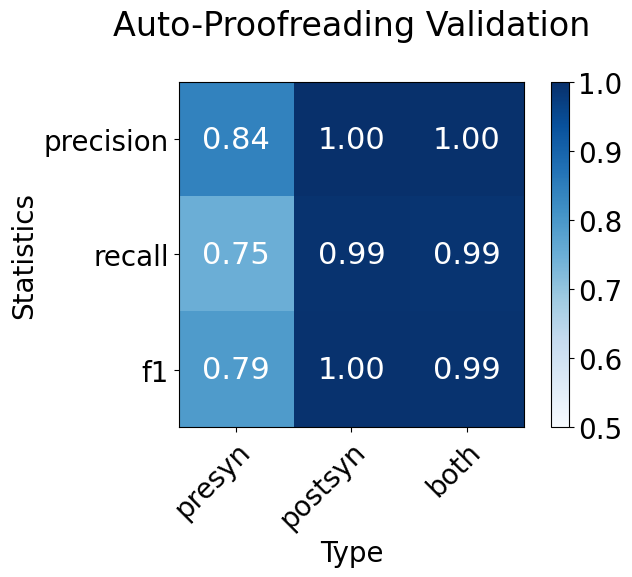

In [10]:
training_df = validation_table_pd[validation_table_pd["old_segment_id"].isin(training_set)]
vu.validation_df_to_score_plot(training_df)

# With the held out neurons

In [11]:
held_out_df = validation_table_pd[~validation_table_pd["old_segment_id"].isin(training_set)]

Segment Id = 864691134988385914
Postsyn counts:
TP:315644
TN:117122
FP:7960
FN:8388
Presyn counts:
TP:863
TN:16809
FP:301
FN:286


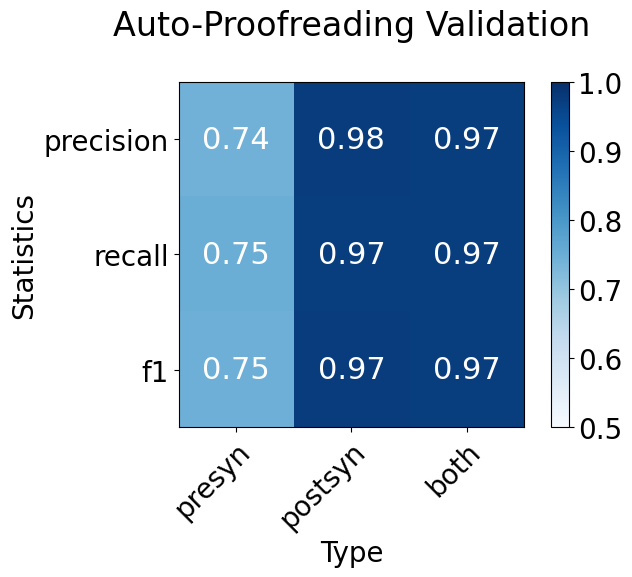

In [12]:
vu.validation_df_to_score_plot(held_out_df)

In [13]:
n_somas,n_glia = held_out_df["n_somas"].to_numpy(),held_out_df["n_glia"].to_numpy()

In [14]:
n_somas

array([1, 2, 2, 1, 2, 1, 1, 1, 1, 5, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2,
       2, 2, 1, 1, 1, 1, 3, 1, 1, 1, 3, 2, 1, 4, 1, 2, 1, 1, 1, 2, 2, 1,
       2, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2,
       2, 1])

In [15]:
n_glia

array([0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0])

In [16]:
len(np.where(n_somas>1)[0])/len(n_somas)

0.3382352941176471

In [17]:
np.sum(n_glia)

4

# Overall Accuracy

Segment Id = 864691134988385914
Postsyn counts:
TP:530224
TN:118267
FP:8294
FN:9907
Presyn counts:
TP:2568
TN:27268
FP:622
FN:858


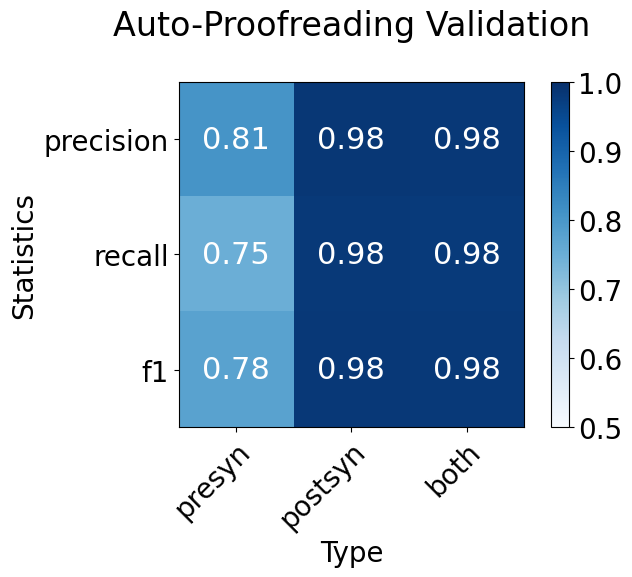

In [18]:
vu.validation_df_to_score_plot(validation_table_pd)

# on the training set

In [ ]:
curr_table2 = ((minnie.AutoProofreadValidationScore5() * minnie.AutoProofreadValidationSegmentMap4())
 & (dj.U("old_segment_id") & minnie.AutoProofreadValidationBorderNeurons().proj(old_segment_id="segment_id")))
curr_table2

In [ ]:
curr_table = ((minnie.AutoProofreadValidationScore4() * minnie.AutoProofreadValidationSegmentMap4())
 & (dj.U("old_segment_id") & minnie.AutoProofreadValidationBorderNeurons().proj(old_segment_id="segment_id")))
curr_table

In [ ]:
seg_ids,pre_recall_v4 = curr_table.fetch("segment_id","pre_recall")
pre_recall_v5 = curr_table2.fetch("pre_recall")

In [ ]:
recall_diff = (pre_recall_v4 - pre_recall_v5)
indices_recall_diff = np.where(recall_diff > 0)[0]
print(recall_diff[indices_recall_diff])
print(seg_ids[indices_recall_diff])

In [ ]:
curr_table2 & dict(segment_id=864691135293126156)

In [ ]:
total_validation_df = vu.table_to_score_plot(curr_table,
                       return_validation_df=True)